# IRISのデータセットをGMMで回帰する

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})

from scipy import linalg

In [2]:
# for sample data
from sklearn import datasets

dataset = datasets.load_iris()
dic = {}
for k,v in zip(dataset.feature_names,dataset.data.T):
    dic[k] = v
df = pd.DataFrame(dic)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


共分散モデルとして以下の４つを用意
1. spherical: 等方的分散（共分散行列が単位行列の定数倍）
2. tied: 共分散がすべてのクラスタで共通
3. diag: 共分散行列が対角
4. full: 共分散についての制約なし

それぞれの共分散モデルに対して、要素数を1-7でふる。
もっともBICが高いモデルがベストモデル

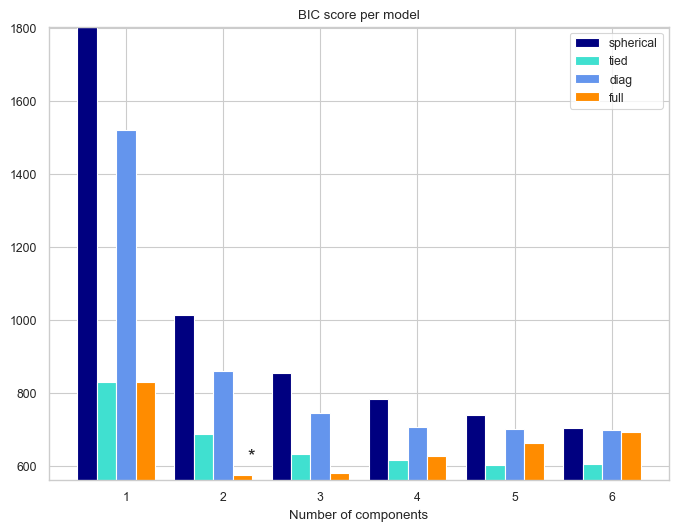

In [3]:
import itertools
# for Gaussian Mixture model for classification
from sklearn import mixture

X = df.values
lowestBIC = np.infty
bic = []
nComponentsRange = range(1, 7)
cvTypes = ['spherical', 'tied', 'diag', 'full']
nInit = 10
for cvType in cvTypes:
    for nComponents in nComponentsRange:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=nComponents,
                                      covariance_type=cvType,n_init =nInit)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowestBIC:
            lowestBIC = bic[-1]
            bestGmm = gmm
            
bic = np.array(bic)
colorIter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])

bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6),dpi=100)
ax = plt.subplot(111)
for i, (cvType, color) in enumerate(zip(cvTypes, colorIter)):
    xpos = np.array(nComponentsRange) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(nComponentsRange):
                                  (i + 1) * len(nComponentsRange)],
                        width=.2, color=color))
plt.xticks(nComponentsRange)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(nComponentsRange)) + .65 + .2 * np.floor(bic.argmin() / len(nComponentsRange))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
ax.set_xlabel('Number of components')
ax.legend([b[0] for b in bars], cvTypes)

# ベストモデルをPCAで解釈する

In [4]:
# for PCA (principal component analysis)
from sklearn.decomposition import PCA

def summaryPCA(pca_,cols):
    print('各次元の寄与率: {0}'.format(pca_.explained_variance_ratio_))
    print('累積寄与率: {0}'.format(sum(pca_.explained_variance_ratio_)))
    print("pca components")
    for k,v in zip(cols,pca_.components_.T):
        print(" ",k,":",", ".join(["%2.2f"%i for i in v]))

def contriPCAPlot(pca_,cols):
    c_p = pca_.components_[:2]

    fig = plt.figure(figsize=(4,4),dpi=100)
    ax = fig.add_subplot(111)
    ax.set_xlim([np.min(c_p[0])-0.1,np.max(c_p[0])+0.1])
    ax.set_ylim([np.min(c_p[1])-0.1,np.max(c_p[1])+0.1])
    # colormap setting
    cm = plt.get_cmap("hsv")
    c = []
    n_ = len(c_p[0])
    for i in range(n_):
        c.append(cm(i/n_))
        
    for i, v in enumerate(c_p.T):
        ax.arrow(x=0,y=0,dx=v[0],dy=v[1],width=0.01,head_width=0.05,
                  head_length=0.05,length_includes_head=True,color=c[i])
    # legend setting 
    patch = []
    for i in range(n_):
        patch.append(mpatches.Patch(color=c[i], label=cols[i] ))
    plt.legend(handles=patch,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    ax.set_title("pca_components_ for each variable")
    plt.show()

def clusterPCAPlot(trans_,df_):
    fig = plt.figure(figsize=(6,4),dpi=100)
    ax = fig.add_subplot(111)
    for i in range(len(df_["clusterId"].unique())): 
        ax.scatter(trans_[df_["clusterId"]==i,0],trans_[df_["clusterId"]==i,1])
    plt.legend(df_["clusterId"].unique())
    plt.show()

以下のフローで解析
1. データの各説明変数値を、平均値0、分散値1に正規化
2. PCAをかけて2つの主成分のみを抽出
3. 解析結果の出力

出力する解析結果は次の3つ
- summary: 寄与率と各主成分を表示した。寄与率は、主成分によってデータの何％を表現できているかを表す指数（共分散行列の固有値をもとに算出される）
- contribution plot: 第一主成分と第二主成分が、説明変数でそれぞれいくらの値を取っているかを表示した。（矢印であることには意味はなさそう）
- cluster plot: PCAで低次元化したデータを、GMMが予測するラベルとあわせて表示した。

各次元の寄与率: [0.72770452 0.23030523]
累積寄与率: 0.9580097536148199
pca components
  sepal length (cm) : 0.52, 0.37
  sepal width (cm) : -0.26, 0.93
  petal length (cm) : 0.58, 0.02
  petal width (cm) : 0.57, 0.07


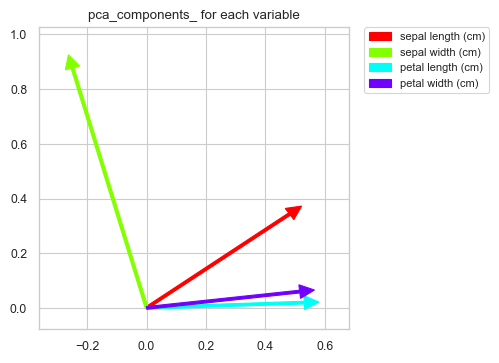

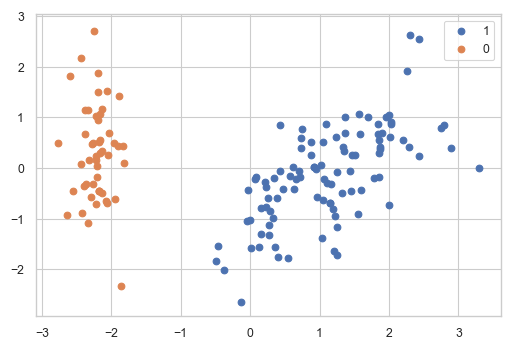

In [5]:
varNames = df.columns
# normalization
dfScaled = df.copy()[varNames]
dfScaled = (dfScaled - dfScaled.mean())/dfScaled.std()

# principal components analysis
pca = PCA(n_components=2)
trans= pca.fit_transform(dfScaled[varNames])

# insert results of GMM clustring 
dfScaled["clusterId"] = bestGmm.predict(X)

# these functions are defined in the previous segment. 
summaryPCA(pca,varNames)
contriPCAPlot(pca,varNames)
clusterPCAPlot(trans,dfScaled)